




**Importación de Librerías** : Importa las librerías necesarias para el manejo de datos y gráficos.

**Funciones de Lectura y Procesamiento** : Define funciones para extraer información del encabezado (`parse_header`) y los datos de tiempo y amplitud (`extract_data`) de archivos de texto.

**Carga de Datos** : Establece la ruta al directorio de datos, identifica archivos con una expresión regular y carga los datos en un diccionario organizado por canal y número de pulso.

**Acceso a los Datos**: Muestra cómo acceder a los datos de un canal y pulso específicos (ejemplo con canal 2, pulso 00001).


In [15]:
import os
import re
import pandas as pd

import pywt
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew
import ipywidgets as widgets
from IPython.display import display


# Function to parse the header and extract number of points
def parse_header(file_lines):
    for line in file_lines:
        if "SegmentSize" in line:
            return int(re.search(r"SegmentSize (\d+)", line).group(1))
    return None

# Function to extract data from a file
def extract_data(filepath):
    with open(filepath, 'r') as file:
        lines = file.readlines()
        num_points = parse_header(lines)
        # Find the line where data starts
        start_idx = next(i for i, line in enumerate(lines) if "Time Ampl" in line) + 1
        data_lines = lines[start_idx:start_idx + num_points]
        data = [list(map(float, line.strip().split())) for line in data_lines]
        return pd.DataFrame(data, columns=['Time', 'Amplitude'])

# Path to the directory containing the files
directory_path = '/home/addles/SDR/BRLY62'



namefile = "data3"  # nombre del archivo generado por el osciloscopio

pattern = re.compile(fr"C(\d){namefile}(\d+)\.txt")
# Dictionary to store data
data = {}

# Iterate over files in the directory
for filename in os.listdir(directory_path):
    match = pattern.match(filename)
    if match:
        channel, pulse = match.groups()
        filepath = os.path.join(directory_path, filename)
        df = extract_data(filepath)
        if channel not in data:
            data[channel] = {}
        data[channel][pulse] = df

# Example: Access data for channel 1, pulse 0001
print(data['1']['00001'])

              Time  Amplitude
0    -3.001750e-07   0.002500
1    -2.996750e-07   0.003167
2    -2.991750e-07   0.002500
3    -2.986750e-07   0.003167
4    -2.981750e-07   0.003167
...            ...        ...
1997  6.983250e-07  -0.003500
1998  6.988250e-07  -0.004167
1999  6.993250e-07  -0.003500
2000  6.998250e-07  -0.003500
2001  7.003250e-07  -0.002167

[2002 rows x 2 columns]


In [16]:
# Dividir la ruta del directorio en cada slash
parts = directory_path.split('/')

# El último elemento de la lista 'parts' es el nombre de la última carpeta
folder_name = parts[-1]

print(folder_name)

BRLY62


## Grafico interactivo de pulso

In [6]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

def interactive_pulse_plot(data, channel):
    """
    Crea un gráfico interactivo para visualizar pulsos a partir de un diccionario de datos, usando un slider para cambiar el número de pulso.
    
    Args:
    - data (dict): Diccionario que contiene los datos de los pulsos, organizados por canal y número de pulso.
    - channel (str): Canal específico del cual se visualizarán los pulsos.
    """
    if channel not in data:
        print(f"No data available for channel {channel}.")
        return
    
    # Ordenar los pulsos y preparar el slider
    pulses = sorted(data[channel].keys())
    pulse_slider = widgets.IntSlider(value=0, min=0, max=len(pulses)-1, step=1, description='Pulse ID:')
    
    # Función para graficar el pulso seleccionado
    def plot_pulse(pulse_index):
        pulse = pulses[pulse_index]
        pulse_data = data[channel][pulse]
        plt.figure(figsize=(10, 5))
        plt.plot(pulse_data['Time'], pulse_data['Amplitude'], label=f"Channel {channel} Pulse {pulse}")
        plt.xlabel("Time")
        plt.ylabel("Amplitude")
        plt.title(f"Pulse {pulse} from Channel {channel}")
        plt.legend()
        plt.grid(True)
        plt.show()

    # Widget interactivo que ajusta la función de trazado basado en la posición del slider
    interactive_plot = widgets.interactive(plot_pulse, pulse_index=pulse_slider)
    display(interactive_plot)

# Ejemplo de uso
selected_channel = '2'  # Ajustar según tus datos
# Asegúrate de que `data` es el diccionario con los datos de pulsos, y que está estructurado correctamente
if selected_channel in data:
    interactive_pulse_plot(data, selected_channel)
else:
    print(f"No data available for Channel {selected_channel}")

interactive(children=(IntSlider(value=0, description='Pulse ID:', max=510), Output()), _dom_classes=('widget-i…

## Ploteo de señal sin filtro

cantidad de pulsos por canal: 3314


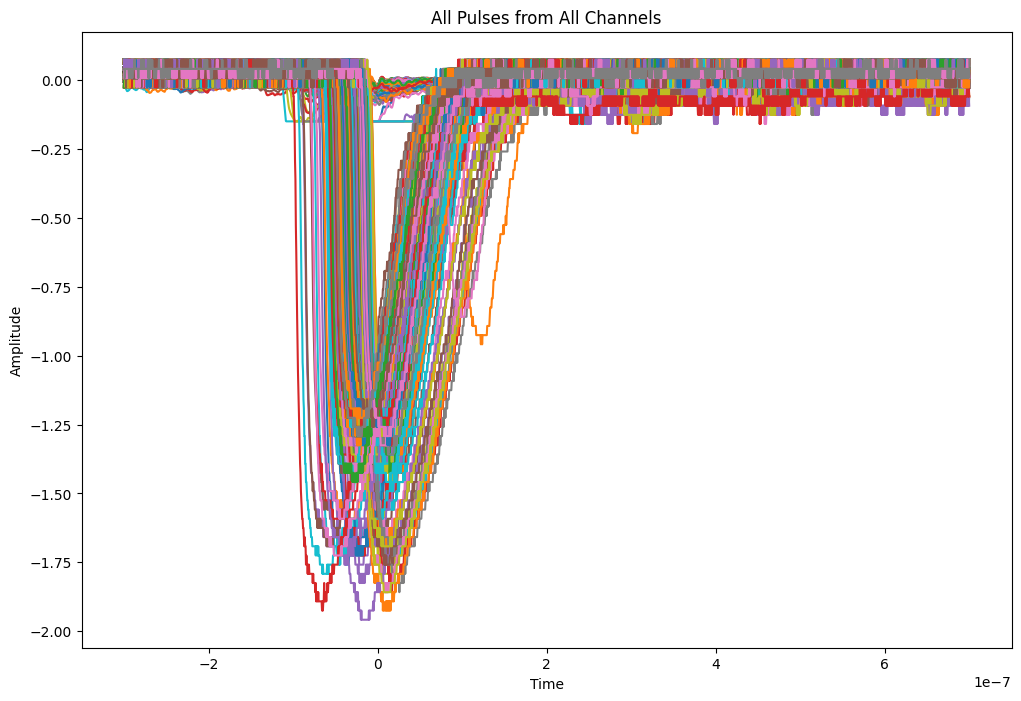

In [17]:
import copy
# Crear una figura y un eje para los gráficos
plt.figure(figsize=(12, 8))
ax = plt.gca()  # Obtener el eje actual

# Iterar sobre cada canal en los datos
for channel, pulses in data.items():
    # Iterar sobre cada pulso en el canal
    for pulse_id, df in pulses.items():
        # Trazar los datos
        ax.plot(df['Time'], df['Amplitude'])

# Configurar las etiquetas y títulos del gráfico
ax.set_title('All Pulses from All Channels')
ax.set_xlabel('Time')
ax.set_ylabel('Amplitude')
  # Mostrar la leyenda




# Hacer una copia profunda de 'pulses' para preservar su estado original
originalcount = copy.deepcopy(len(pulses))

# Mostrar el gráfico
print("cantidad de pulsos por canal:", originalcount)
plt.show()


## Filtrado y Visualización de Pulsos Válidos

Este código realiza el filtrado y la visualización de pulsos que no están saturados, según un umbral definido, y traza los pulsos válidos para todos los canales. Aspectos clave del proceso incluyen:

- **Establecimiento del umbral de saturación**: Define un umbral (Tsatur = -1.5) para identificar pulsos saturados y eliminarlos del análisis.
- **Establecimiento de ubral de corte**: para filtrar pulsos que comienzan anticipados, se cre un umbral de amplitud Tthreshold, y un umbral de tiempo Xthreshold, en donde si el pulso supera cierto umbral antes de cierto umbral de tiempo, entonces es eliminado.
- **Creación de estructuras de datos para los filtrados**: Utiliza un diccionario para almacenar los datos de pulsos que pasan el criterio de filtrado.
- **Iteración y filtrado de datos**: Recorre todos los canales y pulsos, verificando la condición de amplitud para determinar si el pulso está saturado. Los pulsos que cumplen con el criterio son almacenados y trazados.
- **Visualización de resultados**: Muestra un gráfico que representa solo los pulsos que no están afectados por la saturación, ofreciendo una visión clara de los datos válidos.

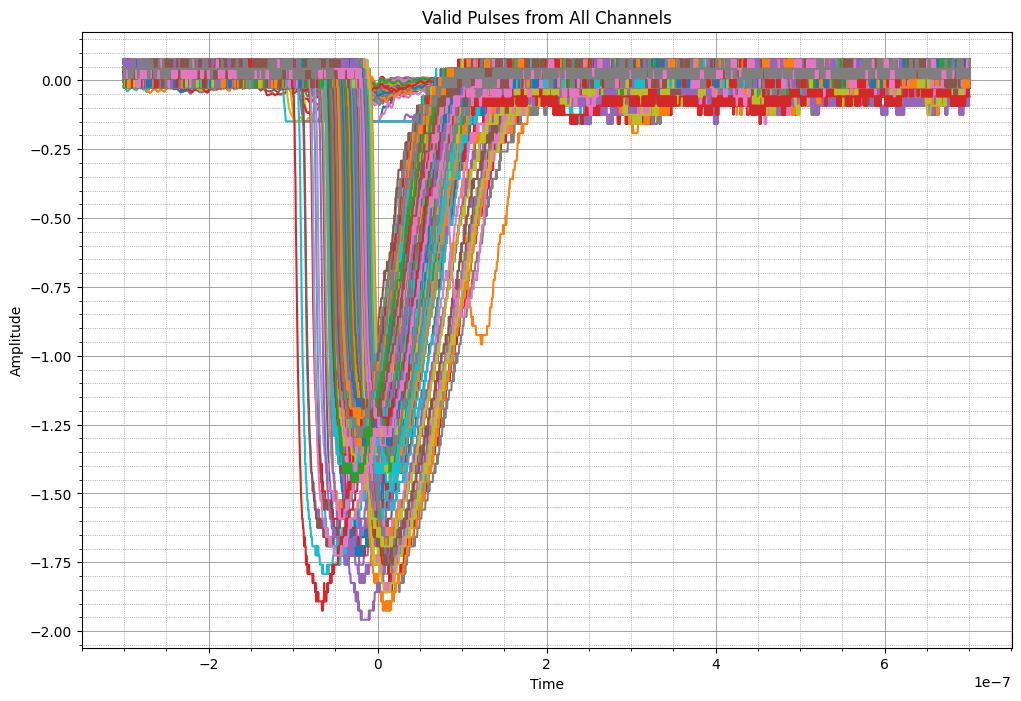

In [21]:
Tsatur = -3.5  # umbral para eliminar pulsos saturados
Tthreshold = -3  # umbral para verificar la amplitud que comienza a bajar
Xthreshold = -2e-7  # umbral en el eje x

# Crear una figura y un eje para los gráficos
plt.figure(figsize=(12, 8))
ax = plt.gca()  # Obtener el eje actual

# Diccionario para almacenar los datos filtrados
filtered_data = {}

# Iterar sobre cada canal en los datos
for channel, pulses in data.items():
    # Preparar un diccionario para los pulsos filtrados de cada canal
    filtered_data[channel] = {}
    # Iterar sobre cada pulso en el canal
    for pulse_id, df in pulses.items():
        # Verificar si algún valor de amplitud en el DataFrame cae por debajo de -1.5
        if not (df['Amplitude'] < Tsatur).any():
            # Verificar si el pulso comienza a bajar en amplitud superando el umbral 
            valid_pulse = True
            for i in range(len(df)):
                if df['Time'].iloc[i] > Xthreshold:
                    break
                if df['Amplitude'].iloc[i] < Tthreshold:
                    valid_pulse = False
                    break
            if valid_pulse:
                # Guardar los datos que pasan el filtro en el nuevo diccionario
                filtered_data[channel][pulse_id] = df
                # Trazar los datos que pasan el filtro
                ax.plot(df['Time'], df['Amplitude'])

# Configurar las etiquetas y títulos del gráfico
ax.set_title('Valid Pulses from All Channels')
ax.set_xlabel('Time')
ax.set_ylabel('Amplitude')

# Configurar la grilla
ax.grid(True, which='both', linestyle='-', linewidth='0.5', color='gray')
ax.minorticks_on()  # Activar las marcas menores
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')

# Mostrar el gráfico
plt.show()

Visualizacion de pulsos por canal 

Name:  data3


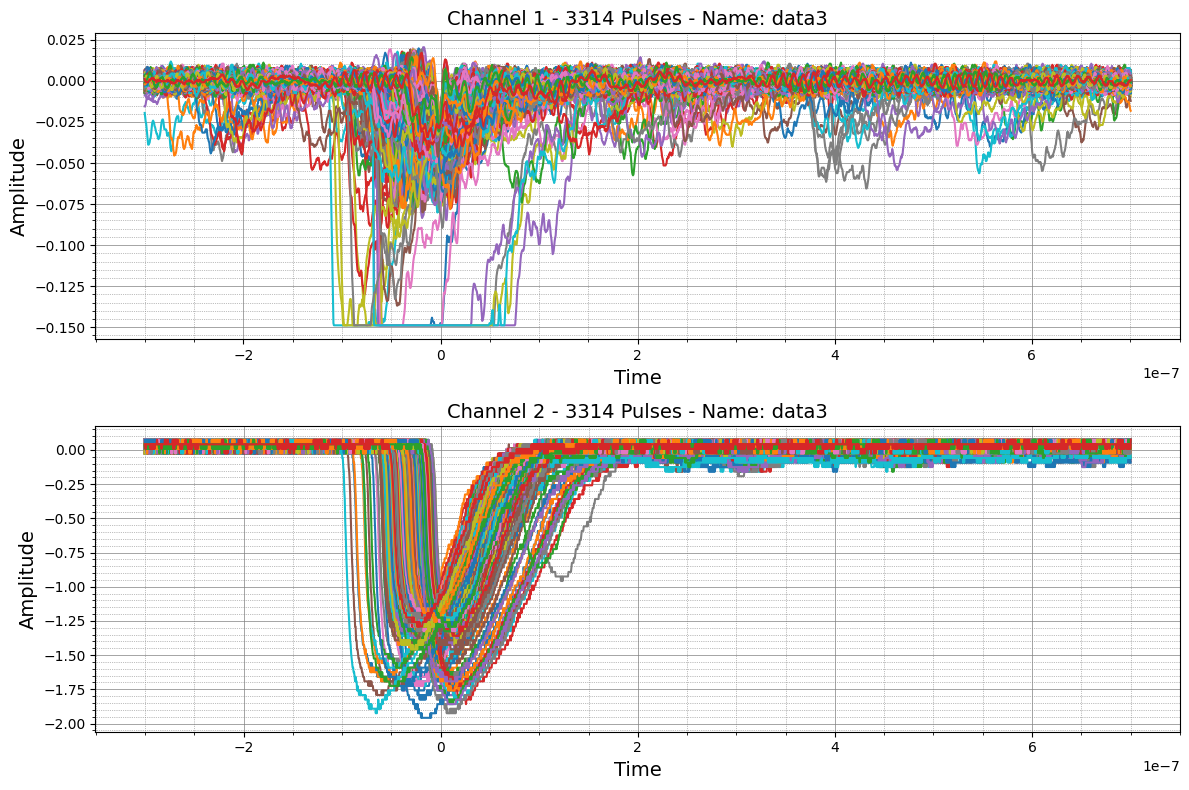

In [22]:
# Determinar cuántos canales únicos hay para configurar los subplots
num_channels = len(filtered_data.keys())
fig, axs = plt.subplots(num_channels, 1, figsize=(12, 4 * num_channels))  # Ajustar el tamaño según el número de canales

# Asegurarse de que axs sea iterable (en caso de que haya solo un canal)
if num_channels == 1:
    axs = [axs]

# Ordenar los canales antes de iterar (asegurando un orden secuencial)
sorted_channels = sorted(filtered_data.items(), key=lambda x: x[0])  # Ordenar por el nombre del canal

# Iterar sobre cada canal en los datos filtrados, ahora ordenados
for ax, (channel, pulses) in zip(axs, sorted_channels):
    num_pulses = len(pulses)  # Contar el número de pulsos en el canal
    # Iterar sobre cada pulso en el canal
    for pulse_id, df in pulses.items():
        # Trazar los datos
        ax.plot(df['Time'], df['Amplitude'])
        
    # Configurar las etiquetas y títulos del gráfico para cada subplot, incluyendo la cantidad de pulsos
    ax.set_title(f'Channel {channel} - {num_pulses} Pulses - Name: {namefile}', fontsize= 14 )
    ax.set_xlabel('Time',fontsize=14)
    ax.set_ylabel('Amplitude', fontsize=14)
    ax.grid(True, which='both', linestyle='-', linewidth='0.5', color='gray')
    ax.minorticks_on()
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')

# Ajustar el layout para evitar superposiciones
plt.tight_layout()

print("Name: ", namefile)

# Mostrar el gráfico
plt.show()

## Corrección de Baseline y Comparación de Pulsos por Canal

Este código implementa un procedimiento para corregir el baseline de pulsos experimentales y visualizar comparativamente los datos originales y corregidos en subplots por canal. Proceso detallado:

- **Configuración de parámetros**: Define una ventana de tiempo para calcular la media del baseline y un umbral para descartar pulsos con un inicio sin baseline que pueden causar problemas.
- **Preparación de subplots**: Crea un arreglo de subplots con dos columnas para cada canal, donde se visualizarán los pulsos antes y después de la corrección.
- **Creación de estructuras de datos para los pulsos corregidos**: Utiliza un diccionario para almacenar los pulsos ajustados de cada canal.
- **Iteración y corrección de datos por canal**: Recorre cada canal y sus pulsos, aplicando un ajuste de baseline cuando es adecuado y trazando los datos en los subplots correspondientes.
- **Configuración individual de cada subplot**: Cada subplot recibe configuraciones de título, etiquetas y grilla para mejorar la visualización y comparación.
- **Visualización de resultados**: Muestra los gráficos resultantes, proporcionando una comparación visual entre los datos originales y los corregidos, resaltando la efectividad del ajuste de baseline.


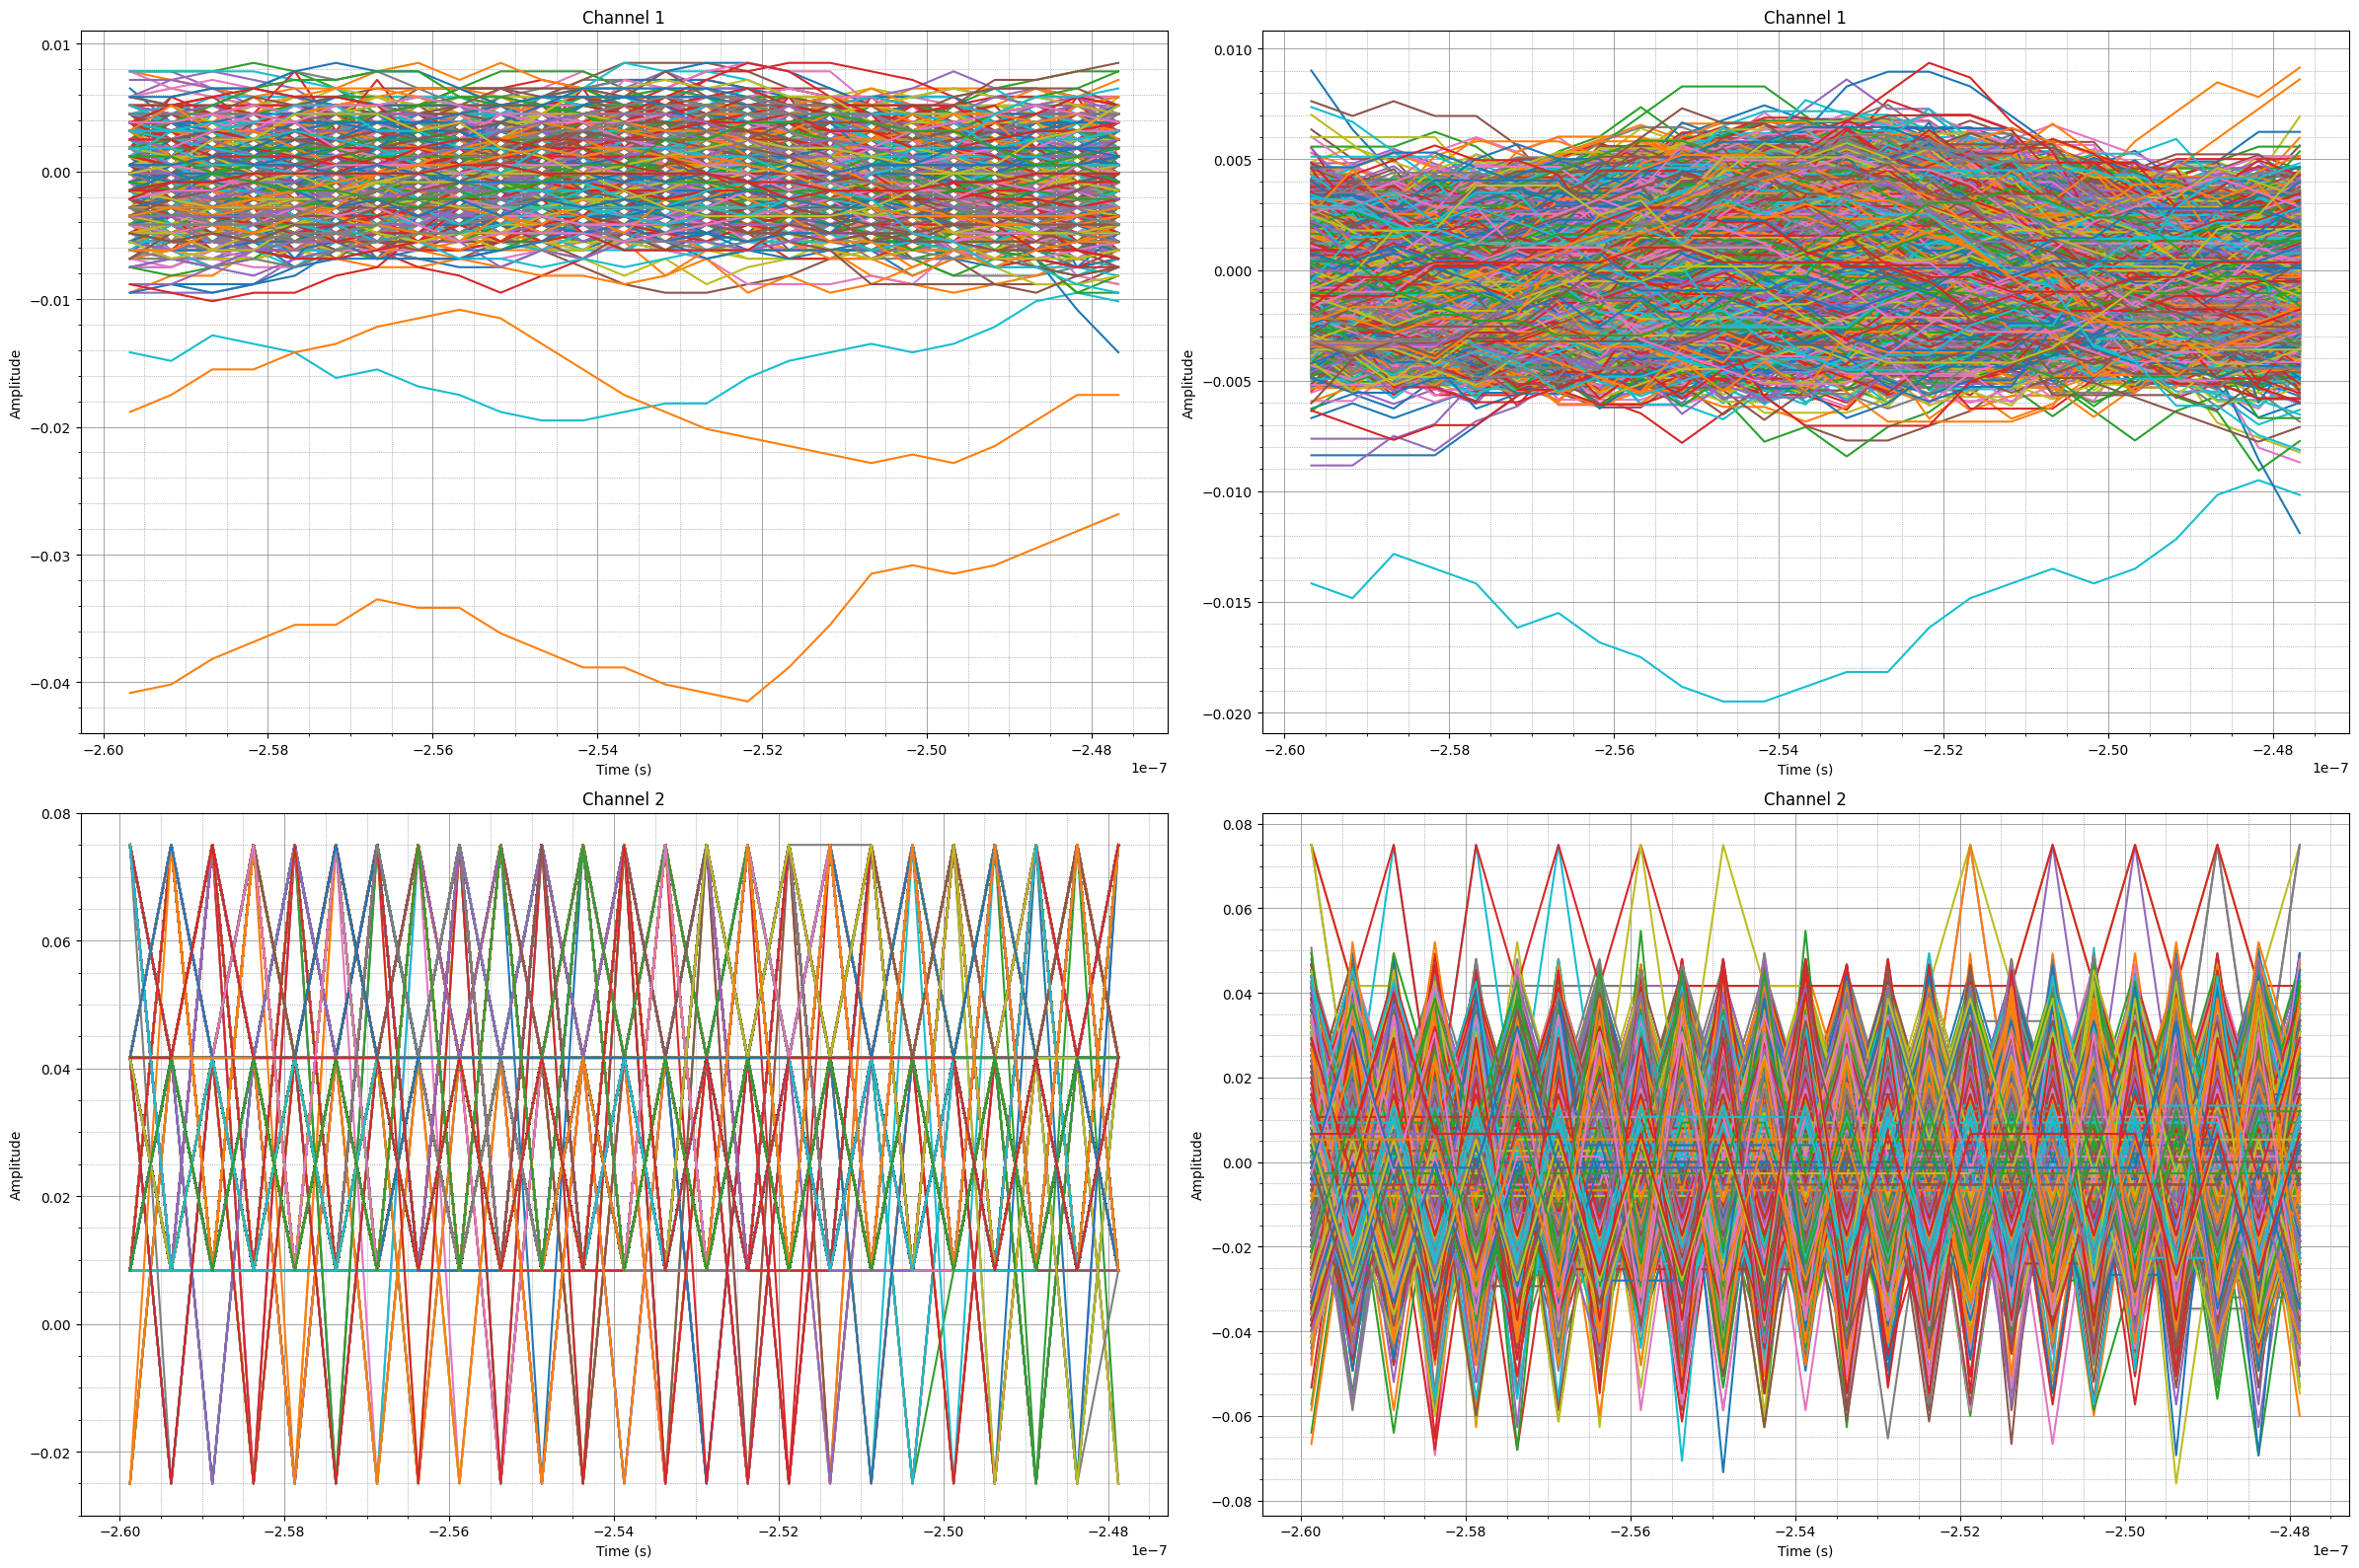

In [25]:
# Ventana de tiempo en la que se calculará la media
tiempo_inicial = -2.6e-7
ancho_ventana = 0.125e-7
tiempo_final = tiempo_inicial + ancho_ventana
# Umbral para descartar de la corrección pulsos que comienzan sin baseline
Usbaseline = -0.01

# Determinar cuántos canales únicos hay para configurar los subplots
num_channels = len(filtered_data.keys())
fig, axs = plt.subplots(num_channels, 2, figsize=(24, 8 * num_channels))  # Ajustar el tamaño según el número de canales

# Diccionario para almacenar los pulsos corregidos
corrected_data = {}

# Asegurarse de que axs sea iterable en todos los casos
if num_channels == 1:
    axs = axs.reshape(1, -1)  # Asegurarse de que axs tenga dos dimensiones

# Iterar sobre cada canal en los datos filtrados, ordenando los canales numéricamente
for ax_row, (channel, pulses) in zip(axs, sorted(filtered_data.items(), key=lambda x: int(x[0]))):
    # Preparar un diccionario para los pulsos corregidos de cada canal
    corrected_data[channel] = {}
    
    for pulse_id, df in pulses.items():
        # Encontrar índices dentro de la ventana de tiempo
        indices_ventana = (df['Time'] >= tiempo_inicial) & (df['Time'] <= tiempo_final)
        
        # Verificar el primer valor de amplitud
        if df['Amplitude'].iloc[0] < Usbaseline:
            df_corregido = df.copy()  # No se hace corrección
        else:
            # Calcular la media en la ventana especificada
            media = df.loc[indices_ventana, 'Amplitude'].mean()
            
            # Restar la media de toda la amplitud para corregir el offset
            df_corregido = df.copy()
            df_corregido['Amplitude'] -= media
        
        # Guardar el pulso corregido en el diccionario
        corrected_data[channel][pulse_id] = df_corregido

        # Trazar los datos originales y corregidos solo en la ventana de tiempo
        ax_row[0].plot(df.loc[indices_ventana, 'Time'], df.loc[indices_ventana, 'Amplitude'])
        ax_row[1].plot(df_corregido.loc[indices_ventana, 'Time'], df_corregido.loc[indices_ventana, 'Amplitude'])
    
    # Configurar las etiquetas y títulos del gráfico para cada subplot
    for ax in ax_row:
        ax.set_title(f'Channel {channel}')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Amplitude')
        ax.grid(True, which='both', linestyle='-', linewidth='0.5', color='gray')
        ax.minorticks_on()
        ax.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
       

# Ajustar el layout para evitar superposiciones
plt.tight_layout()

# Mostrar el gráfico
plt.show()


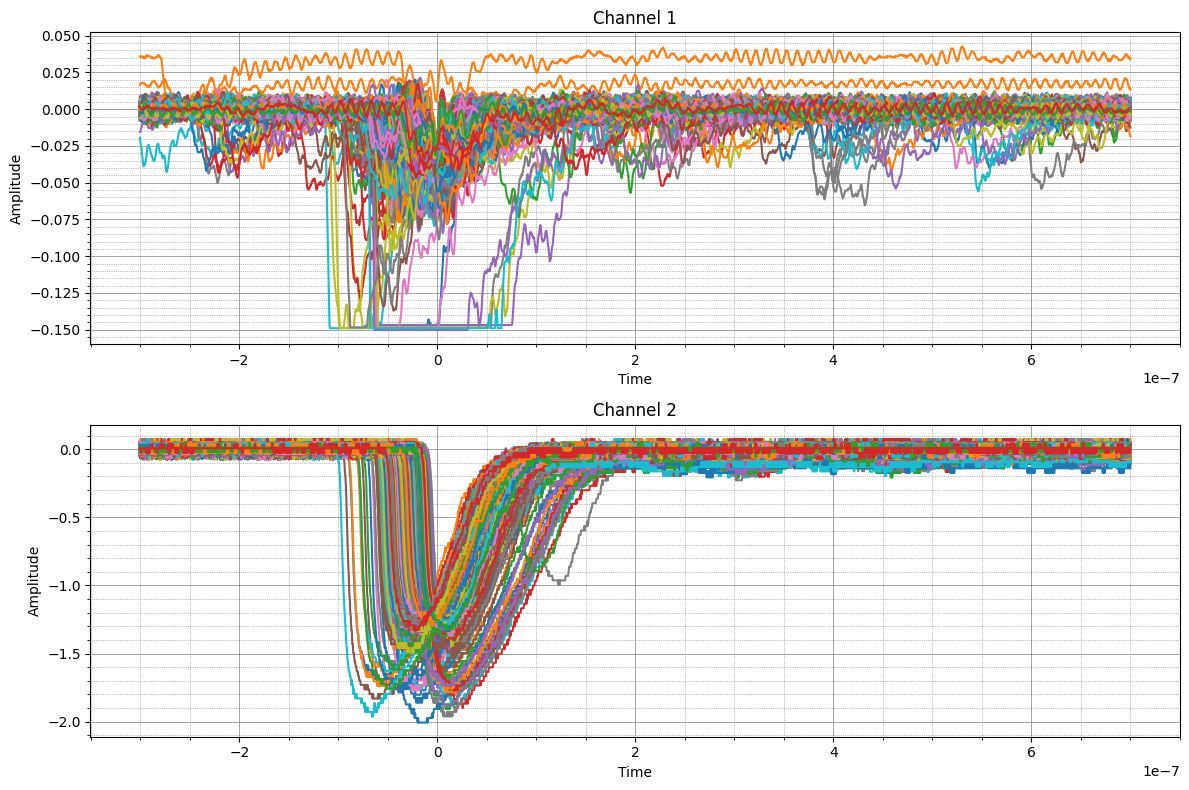

In [26]:

# Determinar cuántos canales únicos hay para configurar los subplots
num_channels = len(corrected_data.keys())
fig, axs = plt.subplots(num_channels, 1, figsize=(12, 4 * num_channels))  # Ajustar el tamaño según el número de canales

# Asegurarse de que axs sea iterable (en caso de que haya solo un canal)
if num_channels == 1:
    axs = [axs]

# Iterar sobre cada canal en los datos filtrados
for ax, (channel, pulses) in zip(axs, sorted(corrected_data.items())):
    # Iterar sobre cada pulso en el canal
    for pulse_id, df in pulses.items():
        # Trazar los datos
        ax.plot(df['Time'], df['Amplitude'])
        
    # Configurar las etiquetas y títulos del gráfico para cada subplot
    ax.set_title(f'Channel {channel}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')
    ax.grid(True, which='both', linestyle='-', linewidth='0.5', color='gray')
    ax.minorticks_on()
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
   

# Ajustar el layout para evitar superposiciones
plt.tight_layout()

# Mostrar el gráfico
plt.show()


# Separacion de datos segun umbral 
- Se define noiseumbral variable que representa el umbral desde el cual se desean separar los datos para catalogar como ruido y señal pura

In [27]:
noiseumbral= -0.1

- Para mayor rapidez ejecutar el codigo A, en donde no se plotean los datos, si se desea ver la separacion de pulsos ejecutar codigo B

Codigo A

In [12]:
# Diccionarios para datos separados por umbral
noisedata = {}
pulsedata = {}

# Iterar sobre cada canal en los datos corregidos
for channel, pulses in corrected_data.items():
    noisedata[channel] = {}
    pulsedata[channel] = {}

    # Iterar sobre cada pulso en el canal
    for pulse_id, df in pulses.items():
        # Verificar si algún dato en el pulso supera el umbral
        if (df['Amplitude'] > noiseumbral).all():  # Si todos los datos están por debajo del umbral, es ruido
            noisedata[channel][pulse_id] = df
        else:  # Si algún dato supera el umbral, es un pulso válido
            pulsedata[channel][pulse_id] = df


Codigo B

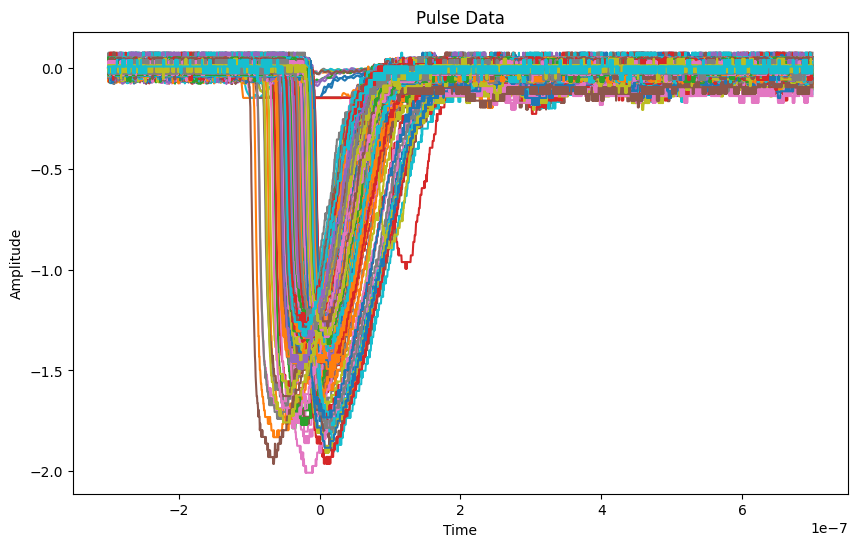

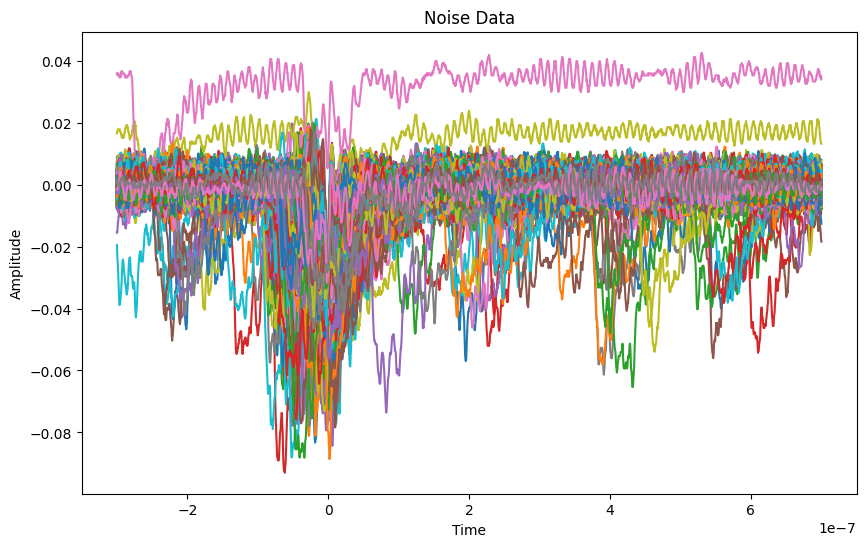

In [28]:


# Supongamos que 'corrected_data' es el diccionario con los datos originales

# Diccionarios para datos separados por umbral
noisedata = {}
pulsedata = {}

# Iterar sobre cada canal en los datos corregidos
for channel, pulses in corrected_data.items():
    noisedata[channel] = {}
    pulsedata[channel] = {}

    # Iterar sobre cada pulso en el canal
    for pulse_id, df in pulses.items():
        # Verificar si algún dato en el pulso supera el umbral
        if (df['Amplitude'] > noiseumbral).all():  # Si todos los datos están por debajo del umbral, es ruido
            noisedata[channel][pulse_id] = df
        else:  # Si algún dato supera el umbral, es un pulso válido
            pulsedata[channel][pulse_id] = df

# Función para plotear los datos
def plot_data(data, title):
    plt.figure(figsize=(10, 6))
    for channel, pulses in data.items():
        for pulse_id, df in pulses.items():
            plt.plot(df['Time'], df['Amplitude'])
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title(title)
    plt.show()

# Graficar todos los datos de pulso
plot_data(pulsedata, 'Pulse Data')

# Graficar todos los datos de ruido
plot_data(noisedata, 'Noise Data')


### Análisis de Pulso Usando Transformada Discreta de Wavelet
**Función de Detección y Filtrado:** Utiliza la librería `pywt` para aplicar transformada de wavelet discreta a la señal, seguida de un filtrado basado en umbral adaptativo.

**Umbrales Definidos:**
- **Umbral de Asimetría:** `skew_threshold` para identificar características de forma de la señal.
- **Umbral de Varianza:** `variance_threshold` para la dispersión de la señal.
- **Umbral de Energía:** `energy_threshold` para la intensidad de la señal.
- **Tasa de Cruce por Cero:** `zero_crossing_rate_threshold` para la frecuencia de cambios de signo en la señal.

**Funciones Auxiliares:**
- **Tasa de Cruce por Cero:** Calcula cuántas veces la señal cambia de positivo a negativo o viceversa.
- **Energía de la Señal:** Suma del cuadrado de la señal para medir la potencia total.

**Procesamiento de Datos:**
Itera sobre cada canal y pulso en los datos con ruido, aplicando filtros y clasificando los pulsos en `pulsesinnoise0` si pasan todos los umbrales, o en `pulsesnoise0` si no.

**Visualización Interactiva:**
Utiliza `ipywidgets` para crear controles interactivos que permiten visualizar y comparar pulsos filtrados y ruido por canal, mejorando la interpretación de los resultados.


In [35]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew

# Función para realizar la transformada de wavelet discreta y filtrar la señal
def detect_pulses_dwt(signal, wavelet='db4', level=4):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    # Reconstruir la señal a partir de los coeficientes de detalle de alta frecuencia
    thresholded_coeffs = [pywt.threshold(c, np.std(c)/2, mode='soft') for c in coeffs]
    reconstructed_signal = pywt.waverec(thresholded_coeffs, wavelet)
    return reconstructed_signal

# Parámetros de umbral
skew_threshold = -1
variance_threshold = 0.001
energy_threshold = 0.1
zero_crossing_rate_threshold = 500

def zero_crossing_rate(signal):
    zero_crossings = np.where(np.diff(np.sign(signal)))[0]
    return len(zero_crossings)

def signal_energy(signal):
    return np.sum(signal**2)

pulsesinnoise0 = {}
pulsesnoise0 = {}

for channel, pulses in noisedata.items():
    pulsesinnoise0[channel] = {}
    pulsesnoise0[channel] = {}
    for pulse_id, df in pulses.items():
        amplitude = df['Amplitude']
        filtered_amplitude = detect_pulses_dwt(amplitude)
        if (
            skew(filtered_amplitude) < skew_threshold and
            np.var(filtered_amplitude) < variance_threshold and
            signal_energy(filtered_amplitude) > energy_threshold and
            zero_crossing_rate(filtered_amplitude) < zero_crossing_rate_threshold
        ):
            pulsesinnoise0[channel][pulse_id] = df
        else:
            pulsesnoise0[channel][pulse_id] = df

import ipywidgets as widgets
from IPython.display import display

def interactive_pulse_plot(filtered_data, noise_data, channel):
    if channel not in filtered_data or channel not in noise_data:
        print(f"No data available for channel {channel}.")
        return
    
    filtered_pulses = sorted(filtered_data[channel].keys())
    noise_pulses = sorted(noise_data[channel].keys())
    filtered_pulse_slider = widgets.IntSlider(value=0, min=0, max=len(filtered_pulses)-1, step=1, description='Filtered Pulse ID:')
    noise_pulse_slider = widgets.IntSlider(value=0, min=0, max=len(noise_pulses)-1, step=1, description='Noise Pulse ID:')

    def plot_pulses(filtered_pulse_index, noise_pulse_index):
        filtered_pulse_id = filtered_pulses[filtered_pulse_index]
        noise_pulse_id = noise_pulses[noise_pulse_index]
        filtered_df = filtered_data[channel][filtered_pulse_id]
        noise_df = noise_data[channel][noise_pulse_id]
        
        fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
        
        axes[0].plot(filtered_df['Time'], filtered_df['Amplitude'], label=f"Channel {channel} Filtered Pulse {filtered_pulse_id}")
        axes[0].set_xlabel("Time")
        axes[0].set_ylabel("Amplitude")
        axes[0].set_title(f"Filtered Pulse {filtered_pulse_id} from Channel {channel}")
        axes[0].legend()
        axes[0].grid(True)
        
        axes[1].plot(noise_df['Time'], noise_df['Amplitude'], label=f"Channel {channel} Noise Pulse {noise_pulse_id}", color='r')
        axes[1].set_xlabel("Time")
        axes[1].set_ylabel("Amplitude")
        axes[1].set_title(f"Noise Pulse {noise_pulse_id} from Channel {channel}")
        axes[1].legend()
        axes[1].grid(True)
        
        plt.tight_layout()
        plt.show()

    interactive_plot = widgets.interactive(plot_pulses, filtered_pulse_index=filtered_pulse_slider, noise_pulse_index=noise_pulse_slider)
    display(interactive_plot)

selected_channel = '1'
if selected_channel in pulsesinnoise0 and selected_channel in pulsesnoise0:
    interactive_pulse_plot(pulsesinnoise0, pulsesnoise0, selected_channel)
else:
    print(f"No data available for Channel {selected_channel}")


interactive(children=(IntSlider(value=0, description='Filtered Pulse ID:', max=350), IntSlider(value=0, descri…

# Histogramas

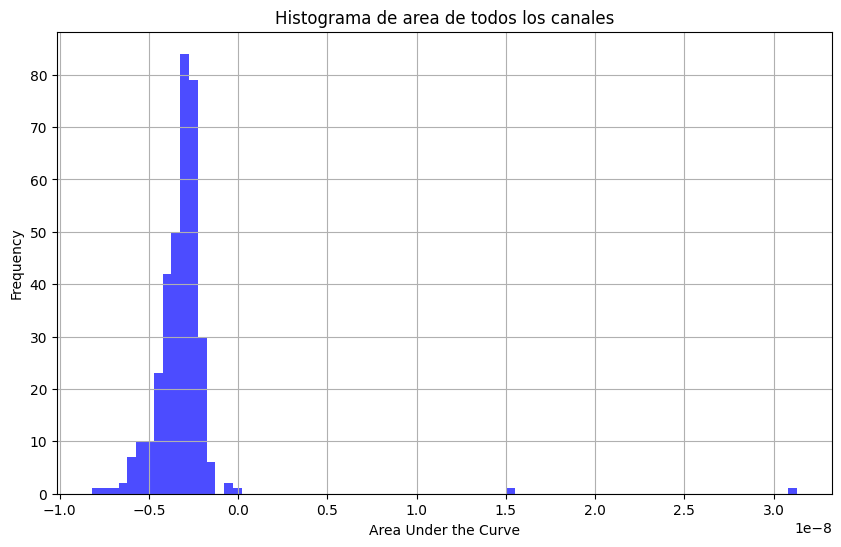

In [36]:
import numpy as np
from scipy.integrate import trapz

# Diccionario para almacenar las áreas bajo la curva
areas = []

for channel, pulses in pulsesinnoise0.items():
    for pulse_id, df in pulses.items():
        # Asumiendo que 'Time' y 'Amplitude' están en las columnas del DataFrame
        area = trapz(df['Amplitude'], df['Time'])
        areas.append(area)




# Configuración de la figura
plt.figure(figsize=(10, 6))
plt.hist(areas, bins=80, color='blue', alpha=0.7)
plt.title('Histograma de area de todos los canales')
plt.xlabel('Area Under the Curve')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


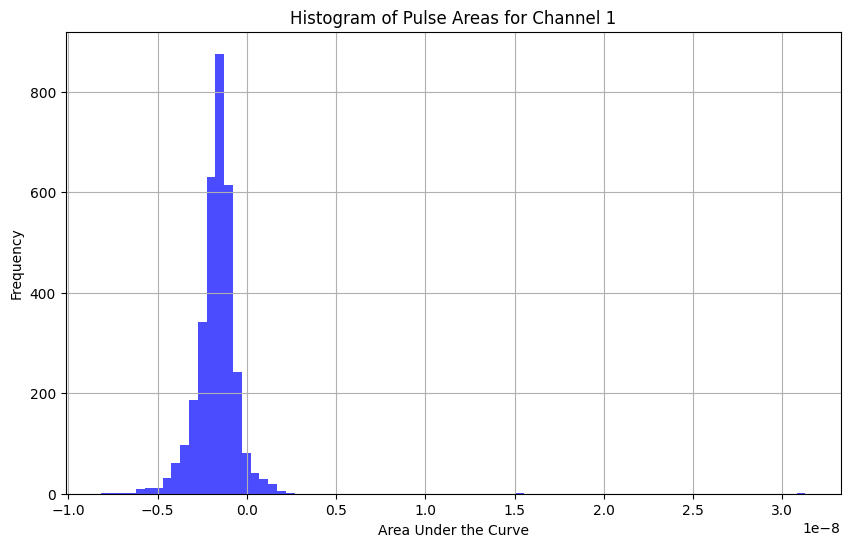

No valid pulses to plot in Channel 2


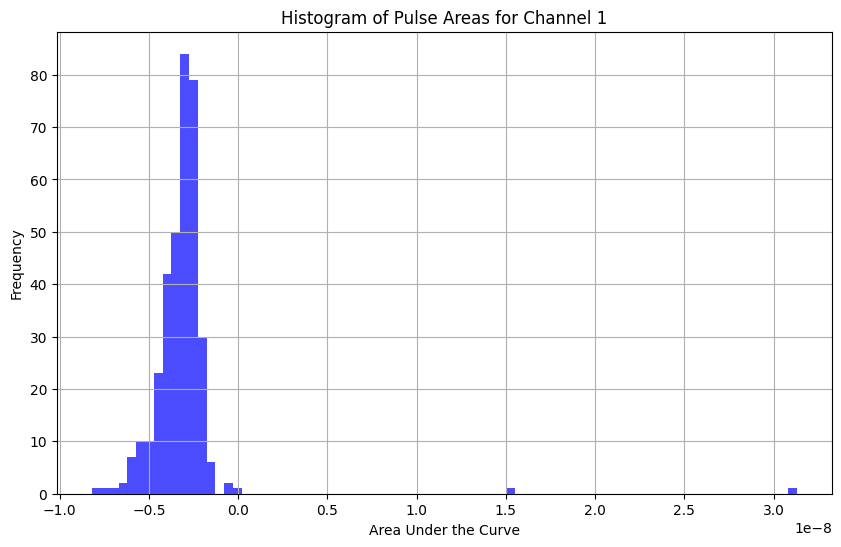

No valid pulses to plot in Channel 2


In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapz

# Iterar sobre cada canal en pulsesinnoise0
for channel, pulses in pulsesinnoise0.items():
    areas = []  # Lista para almacenar las áreas bajo la curva de los pulsos en el canal actual
    
    # Calcular el área bajo la curva para cada pulso en el canal
    for pulse_id, df in pulses.items():
        # Asumiendo que 'Time' y 'Amplitude' están en las columnas del DataFrame
        area = trapz(df['Amplitude'], df['Time'])
        areas.append(area)
    
    # Solo plotear si hay áreas calculadas para evitar gráficos vacíos
    if areas:
        plt.figure(figsize=(10, 6))
        plt.hist(areas, bins=80, color='blue', alpha=0.7)  # Puedes ajustar el número de bins según necesidad
        plt.title(f'Histogram of Pulse Areas for Channel {channel}')
        plt.xlabel('Area Under the Curve')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()
    else:
        print(f"No valid pulses to plot in Channel {channel}")

# Visualizacion de pulsos filtrados

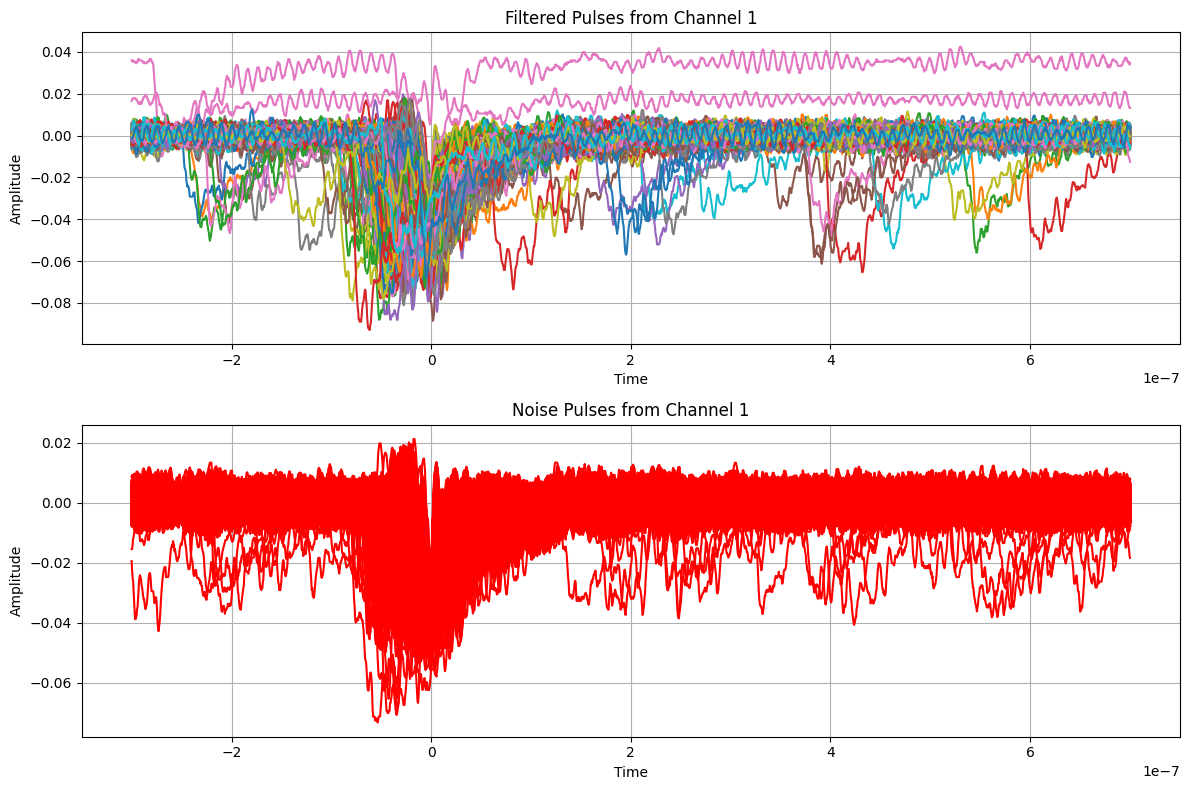

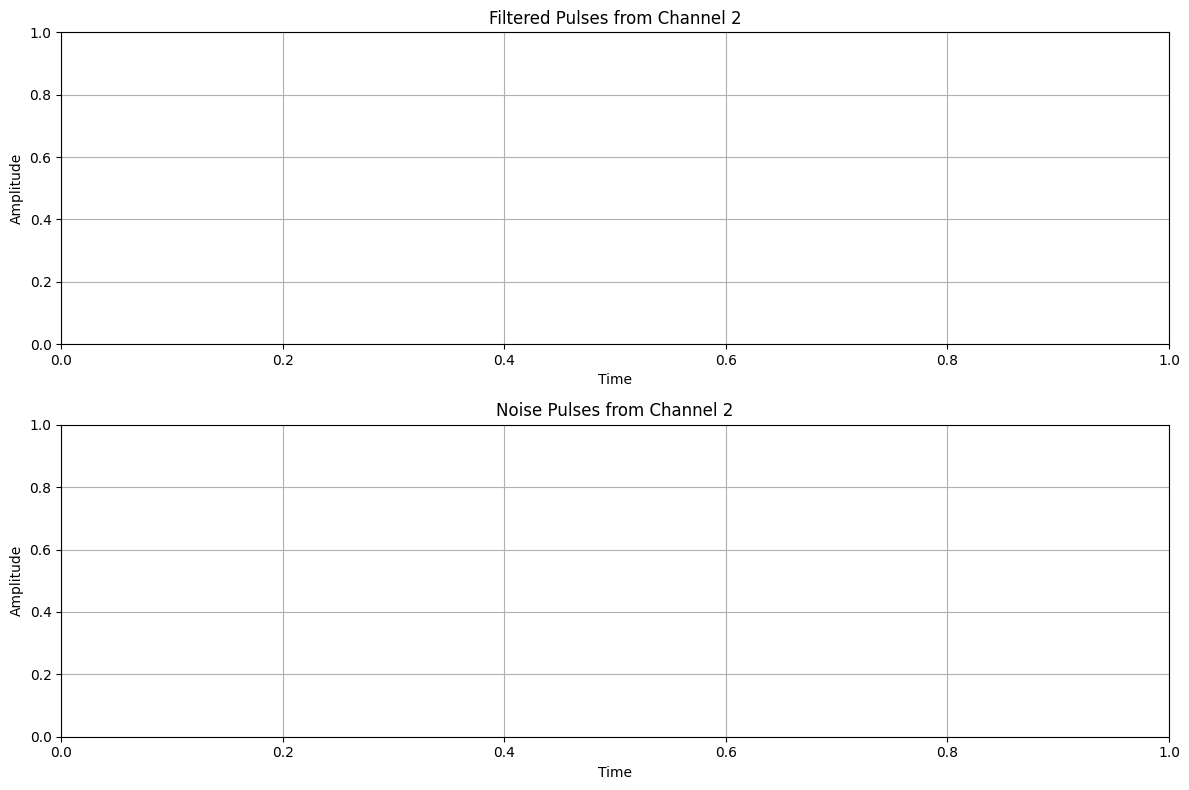

In [40]:

import matplotlib.pyplot as plt

def plot_all_channels(filtered_data, noise_data):
    channels = sorted(set(filtered_data.keys()).union(set(noise_data.keys())))
    
    for channel in channels:
        fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
        
        if channel in filtered_data:
            filtered_pulses = filtered_data[channel]
            for pulse_id, df in sorted(filtered_pulses.items()):
                axes[0].plot(df['Time'], df['Amplitude'])
            axes[0].set_xlabel("Time")
            axes[0].set_ylabel("Amplitude")
            axes[0].set_title(f"Filtered Pulses from Channel {channel}")
            axes[0].grid(True)
        
        if channel in noise_data:
            noise_pulses = noise_data[channel]
            for pulse_id, df in sorted(noise_pulses.items()):
                axes[1].plot(df['Time'], df['Amplitude'], color='r')
            axes[1].set_xlabel("Time")
            axes[1].set_ylabel("Amplitude")
            axes[1].set_title(f"Noise Pulses from Channel {channel}")
            axes[1].grid(True)
        
        plt.tight_layout()
        plt.show()

# Asumimos que pulsesinnoise0 y pulsesnoise0 ya están definidos y llenos de datos
plot_all_channels(pulsesinnoise0, pulsesnoise0)

